In [1]:
import numpy as np
import pandas as pd
import pickle
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from matplotlib import pyplot as plt
import os 
from functions import *
from enrichment import *
from matplotlib_venn import venn2, venn3
from dna_features_viewer import GraphicFeature, GraphicRecord
from scipy import stats
import networkx as nx
from scipy.optimize import curve_fit
import random
import seaborn as sns
from dna_features_viewer import GraphicFeature, GraphicRecord
from scipy import stats

# Load dataset

In [2]:
gb_features = pd.read_csv('../data/genome/GCA_000203855.3_ASM20385v3_feature_table.txt',sep='\t')
gb_features = (gb_features[gb_features['# feature']=='gene']).reset_index().drop(['index'],axis=1)
gb_features = gb_features[['start','end','strand','feature_interval_length','symbol','locus_tag']]
gb_features = ( gb_features.dropna(subset=['locus_tag']) ).reset_index().drop(['index'],axis=1)
gb_features['symbol'] = gb_features['symbol'].fillna(gb_features['locus_tag'])

ref_features = pd.read_csv('../data/genome/GCF_000203855.3_ASM20385v3_feature_table.txt',sep='\t')
ref_features = ( ref_features[ref_features['# feature']=='gene']).reset_index().drop(['index'],axis=1)
ref_features = ref_features[['start','end','strand','feature_interval_length','symbol','attributes']]
ref_features = ( ref_features.dropna(subset=['attributes']) ).reset_index().drop(['index'],axis=1)
locus_tag=[]
for i in range(len(ref_features.index)):
    att = list(ref_features['attributes'])[i]
    if 'old_locus_tag=' in str( att ):
        locus_tag.append( str(att.split('=')[1]).strip()  )
    else:
        locus_tag.append('-')
ref_features['locus_tag']=locus_tag
ref_features = ref_features.drop(['attributes'], axis=1)
ref_features['symbol'] = ref_features['symbol'].fillna(ref_features['locus_tag'])

In [3]:
S = pd.read_csv('../data/IMdata/S.csv')
S = pd.read_csv('../data/IMdata/S.csv',index_col=0)
A = pd.read_csv('../data/IMdata/A.csv',index_col=0)
all_gene_ids = list(S.index)
log_rpkm_norm = pd.read_csv('../data/IMdata/log_rpkm_norm.csv', index_col=0)
log_rpkm = pd.read_csv('../data/IMdata/log_rpkm.csv',index_col=0)
base_level = log_rpkm[['wt_pH6.2_1','wt_pH6.2_2']].mean(axis=1)

IM_list = list(S.columns)

regulons = load_pickle('../data/IMdata/lpwcfs1_regulons.pkl')
regulators, gene_ids = [],[]
for k in regulons.keys():
    gene_ids += regulons[k]
    regulators += [ k for i in range(len(regulons[k])) ]
trn = pd.DataFrame(zip(regulators,gene_ids), columns=['regulator','gene_id'])

In [4]:
IMs = load_pickle('../data/IMdata/imodulon_genes.pkl')
IM_annotation = pd.read_csv('../data/IMdata/IM_annotation.csv')
IM_thersholds = {}
for im in IM_list:
    IM_thersholds[im] = compute_threshold(S, im ,cutoff=550)

# Compare IM and regulon

In [5]:
def get_abs_pearson(reg_gene, gene_sets, exp_data):
    abs_coeffs = []
    for gene in gene_sets:
        if list(exp_data.index).count(gene) == 1:
            coeff, pv = stats.pearsonr( exp_data.loc[reg_gene].values, exp_data.loc[gene].values )
            abs_coeffs.append( abs(coeff) )
    return abs_coeffs 

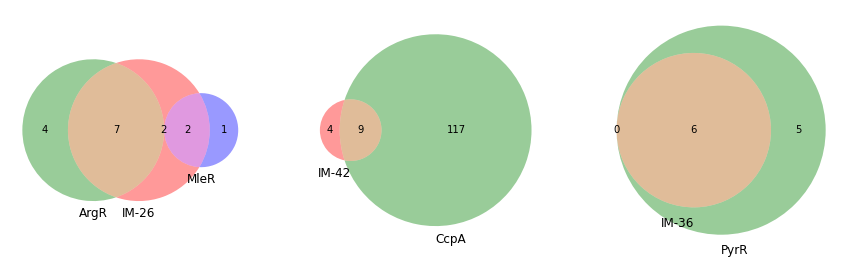

In [6]:
IM2study = ['26','42','36']
fig, axs = plt.subplots(1,3, figsize=(15,6))
for i in range(len(IM2study)):
    ax = axs[i]
    im = IM2study[i]
    im_annot = list(IM_annotation[IM_annotation['IM']==int(im)]['Regulator annotation'])[0]
    if '/' in im_annot:
        regs = im_annot.split('/')
        venn3([set(IMs[im]),set(regulons[regs[0]]), set(regulons[regs[1]])],
             set_labels=['IM-'+im, regs[0],regs[1] ] ,ax = ax)
    elif '+' in im_annot:
        regs = im_annot.split('+')
        venn3([set(IMs[im]),set(regulons[regs[0]]), set(regulons[regs[1]])],
             set_labels=['IM-'+im, regs[0],regs[1] ] ,ax = ax)
    else:
        venn2( [set(IMs[im]),set(regulons[ im_annot ])],
             set_labels=['IM-'+im, im_annot  ], ax = ax )
# plt.savefig('../../../../ICA_LP/Figures/IMvsReg_venn.svg',format='svg',dpi=150)

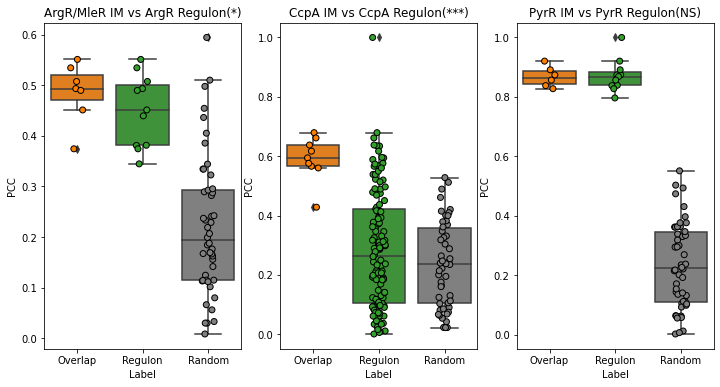

In [7]:
IM2study = ['26','42','36']
reg_genes = ['lp_1411','lp_2256','lp_2704']
regulators = ['ArgR','CcpA','PyrR']
color_list = {'Overlap':sns.color_palette("Paired")[7], 
              'Regulon':sns.color_palette("Paired")[3], 
              'Random':'grey' }
fig, axs = plt.subplots(1,3, figsize=(12,6))
for i in range(len(IM2study)):
    ax = axs[i]
    im = IM2study[i]
    im_annot = list(IM_annotation[IM_annotation['IM']==int(im)]['Regulator annotation'])[0]
    coeff_dict = {'Overlap': get_abs_pearson(reg_genes[i], set(IMs[im]).intersection(set(regulons[regulators[i]])), log_rpkm),
                  'Regulon':get_abs_pearson(reg_genes[i], set(regulons[regulators[i]]),log_rpkm),
                  'Random':get_abs_pearson(reg_genes[i], set( random.sample(set(log_rpkm.index),k=50) ), log_rpkm)}
    coeff_list = list(coeff_dict['Overlap']) + list(coeff_dict['Regulon']) + list(coeff_dict['Random'])
    label_list = ['Overlap' for i in range(len(coeff_dict['Overlap']))] +\
                ['Regulon' for i in range(len(coeff_dict['Regulon']))] +\
                ['Random' for i in range(50)]
    temp_pd = pd.DataFrame(zip(coeff_list,label_list),columns=['PCC','Label'])
    sns.boxplot(x="Label", y="PCC",data=temp_pd, palette=color_list, ax = ax)
    sns.stripplot(x="Label", y='PCC', palette=color_list,size=6,edgecolor='black',linewidth=1,data=temp_pd,ax = ax )
    
    
axs[0].set_title('ArgR/MleR IM vs ArgR Regulon(*)')
axs[1].set_title('CcpA IM vs CcpA Regulon(***)')
axs[2].set_title('PyrR IM vs PyrR Regulon(NS)')
# plt.savefig('../../../../ICA_LP/Figures/IMvsReg_pcc.svg',format='svg',dpi=150)

# Dna feature view for MalR+MdxR co-regulation

In [8]:
def get_seqfeature( gene, table ):
    temp_pd = table[table['locus_tag']==gene].reset_index()
    output = {'start':int(temp_pd['start'][0]),'end':int(temp_pd['end'][0]),
            'strand':str(temp_pd['strand'][0]),'label': str(temp_pd['symbol'][0])}
    if str(temp_pd['strand'][0]) == '+':
        output['strand'] = +1
    else:
        output['strand'] = -1
    if str(temp_pd['symbol'][0]) == gene:
        output['label'] = gene
    else:
        output['label'] = str(temp_pd['symbol'][0])+'('+gene+')'
    return output
        

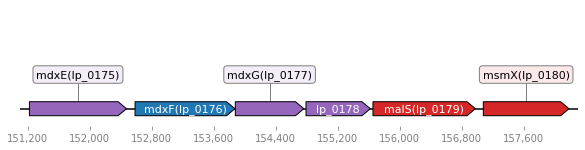

In [14]:
features = []
for gene in IMs['47']:
    gf = get_seqfeature( gene, gb_features )
    if gene in regulons['MalR']:
        color = 'tab:purple'
    else:
        color = 'tab:red'
    features.append( GraphicFeature(start=gf['start'], end=gf['end'], strand=gf['strand'], color=color,label= gf['label']) )
features.append(GraphicFeature(start=152585, end=153874, 
                    strand=+1, color='tab:blue',label= 'mdxF(lp_0176)' ) )
record = GraphicRecord(first_index=151100,sequence_length=7200, features=features);
ax, _  = record.plot(figure_width=10);
# ax.figure.savefig('../../../../ICA_LP/Figures/IM-47-genes.svg',format='svg')

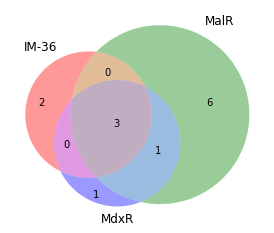

In [49]:
fig,ax=plt.subplots()
venn3([set(IMs['47']),set(regulons['MalR']), set(regulons['MdxR'])],
             set_labels=['IM-'+im, 'MalR', 'MdxR' ] ,ax = ax)
# ax.figure.savefig('../../../../ICA_LP/Figures/IM-47venn.svg',format='svg')